In [71]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import matplotlib.pyplot as plt
from glob import glob
from utils.geotif_io import readTiff, writeTiff
import xdem
from utils.lay_stack import lay_stack


In [72]:
### Setting
dir_proj = '/home/xin/Developer-luo/Glacier-in-SETP'
dir_srtm = dir_proj+'/data/dem-data/srtm-c/tiles'
dir_water = dir_proj+'/data/land_cover/water/water-jrc/tiles'      # jrc water map for water mask
dir_rgi60 = dir_proj+'/data/land_cover/rgi60/tiles'                  # rgi glacier data for glacier mask
dir_veg = dir_proj+'/data/land_cover/vegetation/tiles-2010'      # land cover data for forest mask


In [73]:
paths_dem = glob(dir_proj+'/data/aster-stereo/SETP-2001/aster-dem/*/run-DEM_wgs84_filter.tif')    # slave dem


In [74]:
import os
import pyproj
from osgeo import gdal, osr

## Tiled data mosaic and subseting to dem extent
def tiles2extent(dir_tiled_data, extent, path_save):
    '''
    args:
      dir_data: string, directory of the tiled data
      extent: list, [left, right, bottom, up], can be obtained by readTiff() function.
      path_save, str, the file path to be saved. 
    '''
    paths_tile = glob(dir_tiled_data+'/*[!albers].tif')
    ### data mosaic
    paths_tile_sel = imgs_in_extent(paths_img=paths_tile, extent=extent)
    paths_tile_sel = " ".join(paths_tile_sel)
    command = "gdal_merge.py -co COMPRESS=LZW -o tiles_mosaic.tif " + paths_tile_sel
    print(os.popen(command).read())
    ### data subseting
    left, right, bottom, up = extent[0], extent[1], extent[2], extent[3]
    extent_str = ' '.join([str(left), str(up), str(right), str(bottom)])
    command = 'gdal_translate -projwin %s -co COMPRESS=LZW tiles_mosaic.tif %s' % (extent_str, path_save)
    print(os.popen(command).read())
    os.remove('tiles_mosaic.tif')

def coor2coor(srs_from, srs_to, x, y):
    """
    Transform coordinates from srs_from to srs_to
    input:
        srs_from and srs_to: EPSG number, (e.g., 4326, 3031)
        x and y are x-coord and y-coord corresponding to srs_from and srs_to    
    return:
        x-coord and y-coord in srs_to 
    """
    transformer = pyproj.Transformer.from_crs(int(srs_from), int(srs_to), always_xy=True)
    return transformer.transform(x,y)

def imgs_in_extent(paths_img, extent):
  '''
  des: selected imgs that in the given extent.
  arg:
    paths_img: list, images paths;
    extent: the given extent(wgs84). list -> [left, right, bottom, up]
  '''
  paths_imgs_extent = []
  for path_img in paths_img:
    extent_img, espg_code = get_extent(path_img)    
    xs = (extent_img[0], extent_img[1])
    ys = (extent_img[2], extent_img[3])
    if espg_code != '4326':
      lons_img, lats_img = coor2coor(srs_from=espg_code, srs_to='4326', x=xs, y=ys)
    else: 
      lons_img, lats_img = xs, ys
    lon_in_left = lons_img[1]<extent[0]       ### the case that image is on the left of the extent
    lon_in_right = lons_img[0]>extent[1]
    lat_in_up = lats_img[0]>extent[3]
    lat_in_down = lats_img[1]<extent[2]
    img_in = lon_in_left or lon_in_right or lat_in_up or lat_in_down    ## for each case, there is no overlap between the image and extent. 
    if img_in is False:
      paths_imgs_extent.append(path_img)
  return paths_imgs_extent


def get_extent(path_img):
      RS_Data=gdal.Open(path_img)
      im_col = RS_Data.RasterXSize  # 
      im_row = RS_Data.RasterYSize  # 
      im_geotrans = RS_Data.GetGeoTransform()  # 
      im_proj = RS_Data.GetProjection()  # 
      west = im_geotrans[0]
      north = im_geotrans[3]
      east = west + im_geotrans[1] * im_col + im_geotrans[2] * im_row
      south = north + im_geotrans[5] * im_row + im_geotrans[4] * im_col
      espg_code = osr.SpatialReference(wkt=im_proj).GetAttrValue('AUTHORITY',1)
      extent = (west, east, south, north)
      return extent, espg_code



In [81]:
paths_srtm_tile = glob(dir_proj+'/data/dem-data/srtm-c/tiles/*[!albers].tif')
for path_srtm_tile in paths_srtm_tile: 
    tile_id = os.path.basename(path_srtm_tile)
    path_wat = 'data/land_cover/water/water-jrc/tiles/'+tile_id
    path_gla = 'data/land_cover/rgi60//tiles/'+tile_id
    path_veg = 'data/land_cover/vegetation/tiles-2020/'+tile_id
    path_out_stable = 'data/land_cover/stable_cover/tiles-2020/'+tile_id
    lay_stack(path_imgs=[path_srtm_tile, path_wat, path_gla, path_veg], path_out = 'lay_stack.tif')
    lay_stack_img, lay_stack_img_info = readTiff('lay_stack.tif')
    mask_wat_gla_veg = lay_stack_img[:,:,1] + lay_stack_img[:,:,2]*2 + lay_stack_img[:,:,3]*3
    mask_stable = np.where(mask_wat_gla_veg==0, 1, 0)     ### get stable region
    writeTiff(im_data=mask_stable, im_geotrans=lay_stack_img_info['geotrans'], \
                                        im_geosrs=lay_stack_img_info['geosrs'], path_out=path_out_stable)
    # break



Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.
Images layer stacking done.


In [78]:
lay_stack_img_info

{'geoextent': (93.99981512203236, 95.0, 30.0, 31.000238457660895),
 'geotrans': (93.99981512203236,
  0.00027775197944116654,
  0.0,
  31.000238457660895,
  0.0,
  -0.00027776685855620533),
 'geosrs': '4326',
 'row': 3601,
 'col': 3601,
 'bands': 4}

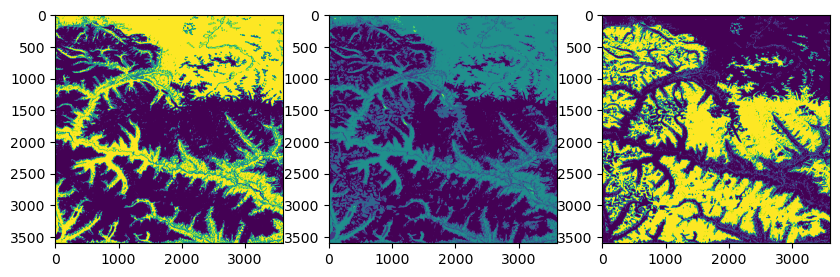

In [68]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(lay_stack[:,:,3])
plt.subplot(1,3,2)
plt.imshow(mask_wat_gla_veg)
plt.subplot(1,3,3)
plt.imshow(mask_stable)


In [22]:
for id, path_dem in enumerate(paths_dem): 
    
    extent_dem, espg_dem = get_extent(path_dem)
    path_srtm_extent = dir_proj+'/srtm_extent.tif'
    path_wat_extent = dir_proj+'/wat_extent.tif'
    path_glacier_extent = dir_proj+'/glacier_extent.tif'
    path_veg_extent = dir_proj+'/veg_extent.tif'
    tiles2extent(dir_tiled_data = dir_srtm, extent = extent_dem, path_save = path_srtm_extent)
    tiles2extent(dir_tiled_data = dir_water, extent = extent_dem, path_save = path_wat_extent)
    tiles2extent(dir_tiled_data = dir_rgi60, extent = extent_dem, path_save = path_glacier_extent)
    tiles2extent(dir_tiled_data = dir_veg, extent = extent_dem, path_save = path_veg_extent)

    ## --1.data reading
    srtm = xdem.DEM(dir_proj+'/srtm_extent.tif')
    dem = xdem.DEM(path_dem).reproject(srtm)   # slave dem
    srtm = srtm.reproject(dem)    # ensure the geo-info are completely the same. some bug for the xdem

    ## --2. water/glacier/forest mask (water:1, glacier:2, forest:3, other:0)
    water_jrc = xdem.DEM(dir_proj+'/wat_extent.tif').reproject(srtm)
    rgi60_mask = xdem.DEM(dir_proj+'/glacier_extent.tif').reproject(srtm)
    veg_mask = xdem.DEM(dir_proj+'/veg_extent.tif').reproject(srtm)
    # forest_mask.data[0] = np.where((forest_mask.data[0]==20) | (forest_mask.data[0]==10) | \
    #                                 (forest_mask.data[0]==30) | (forest_mask.data[0]==40), 1, 0) ### extract vegetation
    mask_wat_gla_veg = water_jrc.data[0]+rgi60_mask.data[0]*2 + veg_mask.data[0]*3
    mask_stable = np.ma.masked_equal(mask_wat_gla_veg ,0).mask     ### get stable region
    # os.remove(path_srtm_extent); os.remove(path_wat_extent); 
    # os.remove(path_glacier_extent); os.remove(path_forest_extent)
    break


0...10...20...30...40...50...60...70...80...90...100 - done.

Input file size is 3600, 3600
0...10...20...30...40...50...60...70...80...90...100 - done.

0...10...20...30...40...50...60...70...80...90...100 - done.

Input file size is 4000, 4000
0...10...20...30...40...50...60...70...80...90...100 - done.

0...10...20...30...40...50...60...70...80...90...100 - done.

Input file size is 3600, 3600
0...10...20...30...40...50...60...70...80...90...100 - done.

0...10...20...30...40...50...60...70...80...90...100 - done.

Input file size is 3459, 3459
0...10...20...30...40...50...60...70...80...90...100 - done.



In [35]:
path = 'data/land_cover/globeland30/2010/tiles/tile_27_96_albers.tif'
img, _ = readTiff(path)


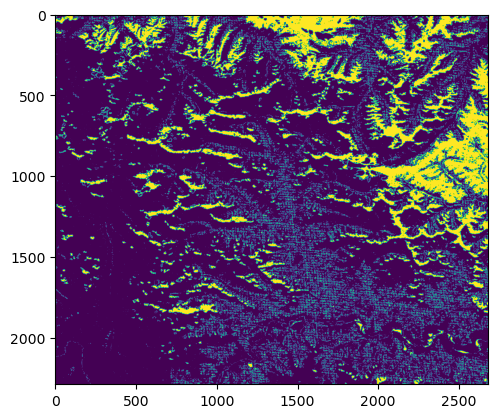

In [24]:
plt.imshow(mask_stable)



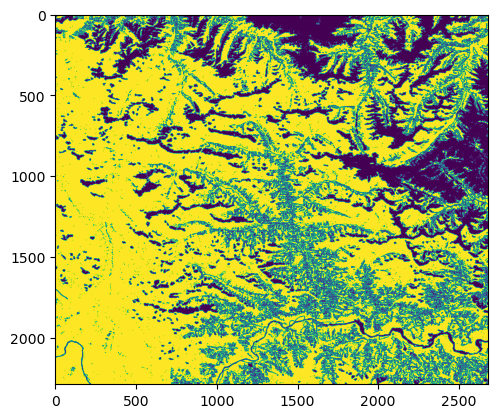

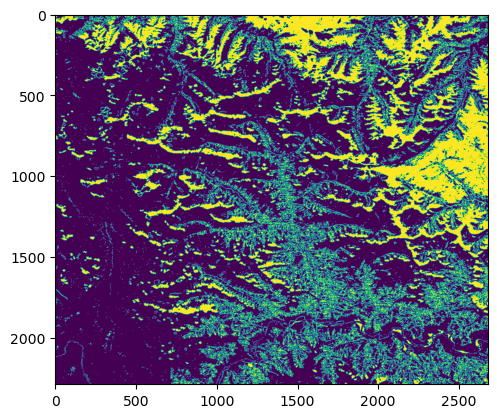

In [56]:
plt.imshow(mask_stable)



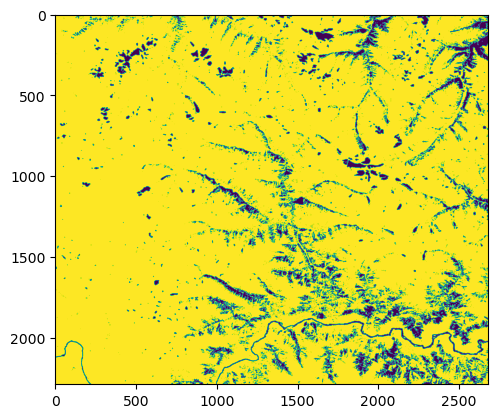

In [33]:

plt.imshow(mask_stable)




In [30]:
path = 'glacier_extent.tif'
path_2 = 'srtm_extent.tif'
path_3 = 'wat_extent.tif'

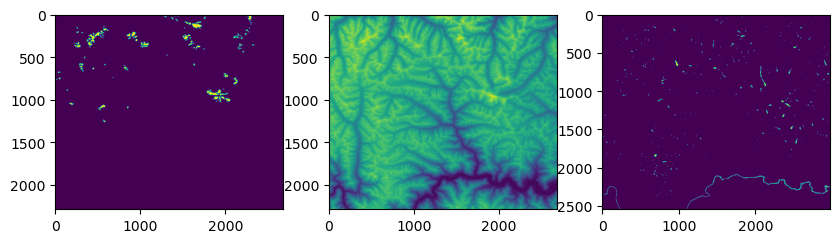

In [31]:
img,_ = readTiff(path)
srtm,_ = readTiff(path_2)
wat,_ = readTiff(path_3)
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(srtm)
plt.subplot(1,3,3)
plt.imshow(wat)


In [10]:
img.min()


-999.0

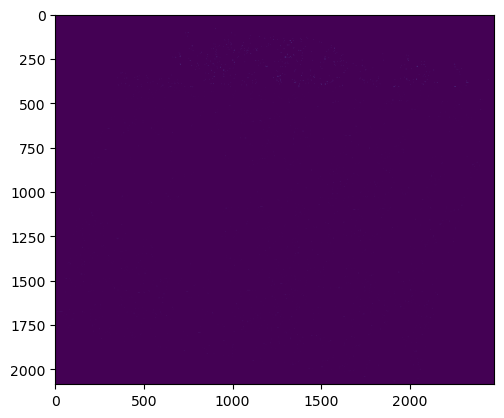

In [8]:
plt.imshow(img)
